In [71]:
# magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from importlib import import_module
from time import time
from pathlib import Path

from simulation_gillespy import build_simulation_dataset
from util import generate_gillespy_traces

# from stochnet_v2.dataset.simulation_gillespy import build_simulation_dataset
from stochnet_v2.dataset.dataset import DataTransformer, HDF5Dataset
from stochnet_v2.static_classes.model import StochNet
from stochnet_v2.dynamic_classes.model import NASStochNet
from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy
from stochnet_v2.static_classes.model import StochNet
# from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy, Trainer
from stochnet_v2.utils.file_organisation import ProjectFileExplorer
# from stochnet_v2.utils.util import generate_gillespy_traces
from stochnet_v2.utils.util import merge_species_and_param_settings, plot_random_traces

from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy
from stochnet_v2.dynamic_classes.trainer import Trainer

# np.set_printoptions(suppress=True, precision=2, linewidth=120)

In [152]:
model_name = 'CUSTOM'
timestep = 0.5
endtime = 20.0
dataset_id = 10
model_id = 10
nb_features = 3
params_to_randomize = ['alpha', 'beta', 'gamma']

In [85]:
model_name = 'SIR'
timestep = 0.5
endtime = 20.0
dataset_id = 1
model_id = 1
nb_features = 2
# params_to_randomize = ['recovery_rate', 'infection_rate', 'death_rate']
params_to_randomize = ['beta', 'gamma']

In [153]:
project_folder = Path('').parent.resolve()/model_name
project_explorer = ProjectFileExplorer(project_folder)
dataset_explorer = project_explorer.get_dataset_file_explorer(timestep, dataset_id)
model_explorer = project_explorer.get_model_file_explorer(timestep, model_id)

body_config_path = model_explorer.body_config_fp
mixture_config_path = model_explorer.mixture_config_fp

In [154]:
CRN_module = import_module(model_name)
CRN_class = getattr(CRN_module, model_name)

In [155]:
# generate traces (the big old problem)

nb_settings = 100
nb_trajectories = 100

nb_histogram_settings = 100
nb_histogram_trajectories = 100


settings = CRN_class.get_initial_settings(nb_settings)
print(f"settings shape: {settings.shape}")
print(f"for each initial setting, we will have {nb_trajectories} trajectories simulated")
df_settings = pd.DataFrame(settings, columns=CRN_class.get_species_names())
print(df_settings)
print(f"\nSaving settings to {dataset_explorer.settings_fp}")
np.save(dataset_explorer.settings_fp, settings)

settings shape: (100, 3)
for each initial setting, we will have 100 trajectories simulated
        S      I    D
0   124.0  125.0  0.0
1   182.0  207.0  0.0
2   282.0  109.0  0.0
3   138.0   18.0  0.0
4   173.0  133.0  0.0
..    ...    ...  ...
95  189.0  144.0  0.0
96  206.0  112.0  0.0
97  158.0  167.0  0.0
98  187.0  245.0  0.0
99  114.0  134.0  0.0

[100 rows x 3 columns]

Saving settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/CUSTOM/dataset/data/0.5/10/settings.npy


In [156]:
dataset = build_simulation_dataset(
    model_name,                              # CUSTOM
    nb_settings,                             # 10
    nb_trajectories,                         # 10
    timestep,                                # 0.1
    endtime,                                 # 10
    dataset_explorer.dataset_folder,         # CUSTOM\dataset\data\0.1\1\
    params_to_randomize=params_to_randomize, # ['alpha', 'beta']
    how='concat'
)

print(f"Saving dataset to {dataset_explorer.dataset_fp}")
np.save(dataset_explorer.dataset_fp, dataset)

print(dataset.shape)

100%|██████████| 100/100 [00:00<00:00, 406.66it/s]

Saving dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/CUSTOM/dataset/data/0.5/10/dataset.npy
(10000, 41, 7)


In [157]:
histogram_settings = CRN_class.get_initial_settings(nb_histogram_settings)
print(f"histogram_settings shape: {histogram_settings.shape}")
print(f"Saving histogram_settings to {dataset_explorer.histogram_settings_fp}")
np.save(dataset_explorer.histogram_settings_fp, histogram_settings)

histogram_dataset = build_simulation_dataset(
    model_name,
    nb_histogram_settings,
    nb_histogram_trajectories,
    timestep,
    endtime,
    dataset_explorer.dataset_folder,
    params_to_randomize=params_to_randomize,
    prefix='histogram_partial_',
    how='stack',
    settings_filename=os.path.basename(dataset_explorer.histogram_settings_fp),
)
print(f"Saving histogram_dataset to {dataset_explorer.histogram_dataset_fp}")
np.save(dataset_explorer.histogram_dataset_fp, histogram_dataset)

histogram_settings shape: (100, 3)
Saving histogram_settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/CUSTOM/dataset/data/0.5/10/histogram_settings.npy


100%|██████████| 100/100 [00:00<00:00, 407.48it/s]

Saving histogram_dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/CUSTOM/dataset/data/0.5/10/histogram_dataset.npy


In [111]:
names = ['time'] + list(reversed(CRN_class.get_species_names())) + params_to_randomize
for i in range(nb_settings):
    df = pd.DataFrame(dataset[i, :, :], columns=names)
    print(df.loc[[0]])
    print()

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.640363  0.082406

   time    D      I     S     alpha      beta     gamma
0   0.0  0.0  278.0  30.0  1.604855  0.6

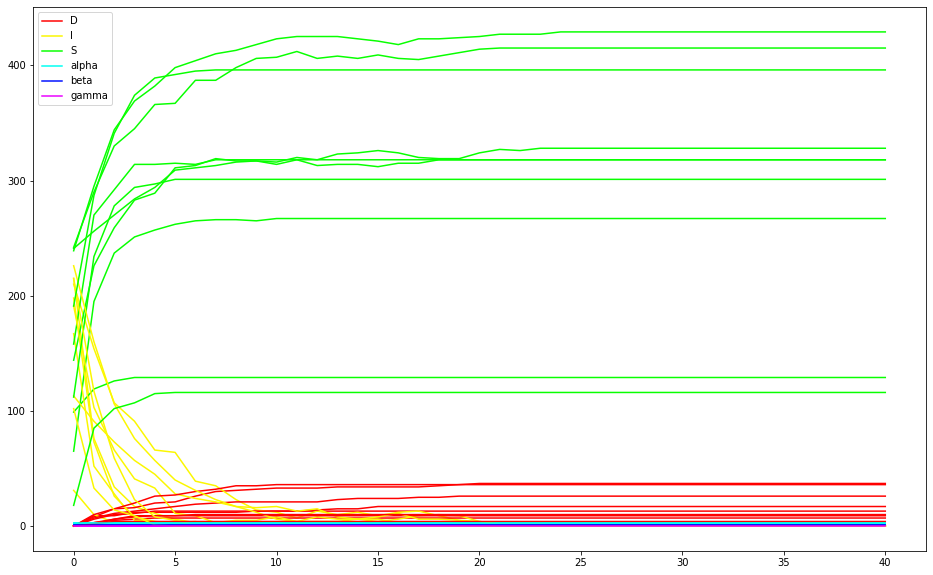

In [158]:
# plotting
n = 10
species_names = list(reversed(CRN_class.get_species_names()))

plt.figure(figsize=(16, 10))
plot_random_traces(dataset, 1, labels=species_names + params_to_randomize)
plt.legend()
plot_random_traces(dataset, n - 1, labels=species_names + params_to_randomize)

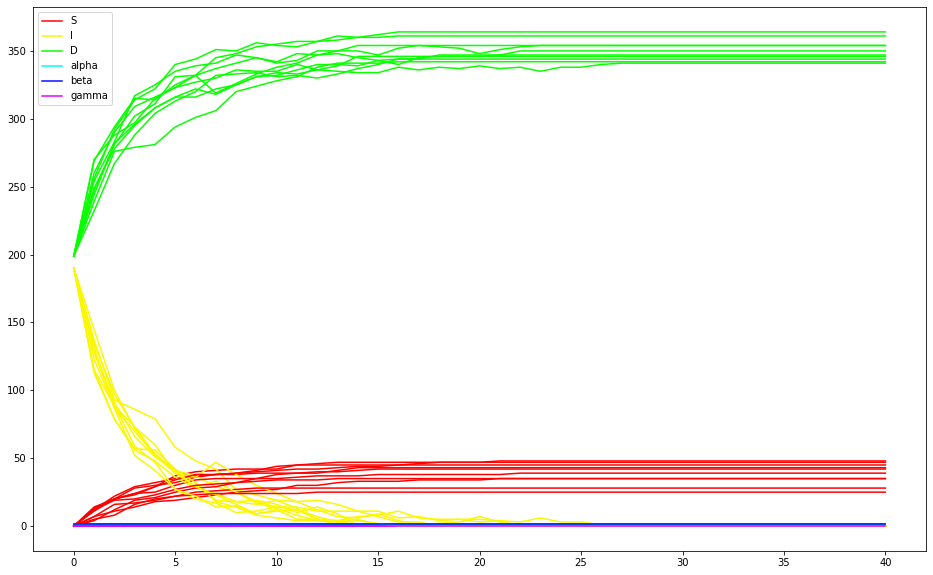

In [159]:
setting_idx = 0
n = 10

plt.figure(figsize=(16, 10))
plot_random_traces(histogram_dataset[setting_idx], 1, labels=CRN_class.get_species_names() + params_to_randomize)
plt.legend()
plot_random_traces(histogram_dataset[setting_idx], n - 1, labels=CRN_class.get_species_names() + params_to_randomize)

In [160]:
dt = DataTransformer(
    dataset_explorer.dataset_fp,
    with_timestamps=True,
    nb_randomized_params=len(params_to_randomize)
)

In [161]:
np.random.seed(42)

dt.save_data_for_ml_hdf5(
    dataset_folder=dataset_explorer.dataset_folder,
    nb_past_timesteps=1,
    test_fraction=0.2,
    keep_timestamps=False,
    rescale=True,
    positivity=False,
    shuffle=True,
    slice_size=100,
    force_rewrite=True
)

100%|██████████| 100/100 [00:00<00:00, 1028.65it/s]


In [162]:
import h5py

data_file = h5py.File(dataset_explorer.train_rescaled_fp, 'r')

x_data = data_file['x']
y_data = data_file['y']

i = 200

dt.scale_back(x_data[i]), dt.scale_back(y_data[i])

ds = HDF5Dataset(dataset_explorer.train_rescaled_fp, 64)

c = 0
for x, y in ds:
    print(f'{x.shape}, {y.shape}')
    c += 1
    if c > 10:
        break
    else:
        continue
    break

(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)
(64, 1, 6), (64, 3)


In [163]:
body_n_cells = 2
body_cell_size = 2
body_expansion_multiplier = 20
body_n_states_reduce = 2
body_kernel_constraint = "none"
body_bias_constraint = "none"
body_kernel_regularizer = "l2"
body_bias_regularizer = "l2"
body_regularizer = "none"

components_hidden_size = "none"
n_normal_diag = 6
n_normal_tril = 0
n_log_normal_tril = 0
components_activation = "none"
components_regularizer = "none"
components_kernel_constraint = "none"
components_bias_constraint = "none"
components_kernel_regularizer = "l2"
components_bias_regularizer = "l2"


body_config = {
    "n_cells": body_n_cells,
    "cell_size": body_cell_size,
    "expansion_multiplier": body_expansion_multiplier,
    "n_states_reduce": body_n_states_reduce,
    "kernel_constraint": body_kernel_constraint,
    "kernel_regularizer": body_kernel_regularizer,
    "bias_constraint": body_bias_constraint,
    "bias_regularizer": body_bias_regularizer,
    "activity_regularizer": body_regularizer,
}

categorical_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "coeff_regularizer": "none",
    "kernel_constraint": body_kernel_constraint,  # unitnorm
    "bias_constraint": body_bias_constraint,  # unitnorm
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_diag_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": "l2",
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

log_normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}



In [164]:
# write config files
mixture_config = \
[["categorical", categorical_config]] + \
[["normal_diag", normal_diag_config] for i in range(n_normal_diag)] + \
[["normal_tril", normal_tril_config] for i in range(n_normal_tril)] + \
[["log_normal_tril", log_normal_tril_config] for i in range(n_log_normal_tril)]

with open(body_config_path, 'w+') as f:
    json.dump(body_config, f, indent='\t')

with open(mixture_config_path, 'w+') as f:
    json.dump(mixture_config, f, indent='\t')

In [166]:
# configure the training strategy
learning_strategy_main = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=7,
    minimal_lr=1e-7,
)

learning_strategy_arch = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-3,
    lr_decay=0.5,
    epochs_tolerance=20,
    minimal_lr=1e-7,
)

learning_strategy_finetune = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=5,
    minimal_lr=1e-7,
)

n_epochs_main = 500
n_epochs_heat_up = 20
n_epochs_interval = 5
n_epochs_arch = 5
n_epochs_finetune = 40
batch_size = 256
dataset_kind = 'hdf5'
add_noise = True
stddev = 0.01

In [167]:
# initilialise the model
nn = NASStochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
)

static_classes.top_layers - DEBUG - Mixture components share nn outputs
static_classes.top_layers - DEBUG - base shape: [None, 120]
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.model - INFO - Model's graph keys saved at /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/CUSTOM/models/0.5/10/graph_keys.json
static_classes.model - INFO - Model created in normal mode.


In [168]:
# train model
ckpt_path = None

ckpt_path = Trainer().train(
    nn,
    n_epochs_main=n_epochs_main,
    n_epochs_heat_up=n_epochs_heat_up,
    n_epochs_arch=n_epochs_arch,
    n_epochs_interval=n_epochs_interval,
    n_epochs_finetune=n_epochs_finetune,
    batch_size=batch_size,
    learning_strategy_main=learning_strategy_main,
    learning_strategy_arch=learning_strategy_arch,
    learning_strategy_finetune=learning_strategy_finetune,
    ckpt_path=ckpt_path,
    dataset_kind=dataset_kind,
    add_noise=add_noise,
    stddev=stddev,
    mode=['search', 'finetune']
)

ckpt_path

dynamic_classes.trainer - INFO - 
Training MAIN...

dynamic_classes.trainer - DEBUG - Total number of trainable vars 138
dynamic_classes.trainer - DEBUG - Total number of main optimizer vars 278
dynamic_classes.trainer - INFO - 
Epoch: 1
dynamic_classes.trainer - INFO -  = Minimal loss value = 0.48907676339149475,
 - 1250 steps took 83.6 seconds, avg_step_time=0.067

dynamic_classes.trainer - INFO -  - test time: 2.9 seconds
dynamic_classes.trainer - INFO - 
Epoch: 2
dynamic_classes.trainer - INFO -  = Minimal loss value = -0.25626370310783386,
 - 1250 steps took 41.0 seconds, avg_step_time=0.033

dynamic_classes.trainer - INFO -  - test time: 2.1 seconds
dynamic_classes.trainer - INFO - 
Epoch: 3
dynamic_classes.trainer - INFO -  = Minimal loss value = -0.9500735998153687,
 - 1250 steps took 40.0 seconds, avg_step_time=0.032

dynamic_classes.trainer - INFO -  - test time: 2.0 seconds
dynamic_classes.trainer - INFO - 
Epoch: 4
dynamic_classes.trainer - INFO -  = Minimal loss value = -1

KeyboardInterrupt: 

In [ ]:
import pickle
from stochnet_v2.utils.util import visualize_genotypes

with open(os.path.join(nn.model_explorer.model_folder, 'genotypes.pickle'), 'rb') as f:
    genotypes = pickle.load(f)

# genotypes
visualize_genotypes(genotypes, f'genotypes_{model_id}')

In [ ]:
from stochnet_v2.utils.evaluation import evaluate
from stochnet_v2.utils.util import plot_random_traces

distance_kind = 'dist'
target_species_names = ['S', 'I']
time_lag_range = [1, 3, 5, 10, 15, 20]
settings_idxs_to_save_histograms = [i for i in range(10)]

histogram_explorer = dataset_explorer.get_histogram_file_explorer(model_id, 0)
nn_histogram_data_fp = os.path.join(histogram_explorer.model_histogram_folder, 'nn_histogram_data.npy')

evaluate(
    model_name=model_name,
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    nb_randomized_params=len(params_to_randomize),
    nb_past_timesteps=1,
    n_bins=100,
    distance_kind=distance_kind,
    with_timestamps=True,
    save_histograms=True,
    time_lag_range=time_lag_range,
    target_species_names=target_species_names,
    path_to_save_nn_traces=nn_histogram_data_fp,
    settings_idxs_to_save_histograms=settings_idxs_to_save_histograms,
)

In [ ]:
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    mode='inference'
)

n_settings = 100
traj_per_setting = 100
n_steps = 41

m = CRN_class(endtime, timestep)

initial_settings = m.get_initial_settings(n_settings)
randomized_params = m.get_randomized_parameters(params_to_randomize, n_settings)

settings = merge_species_and_param_settings(initial_settings, randomized_params)
settings

In [ ]:
setting_idx = 0

curr_state = settings[setting_idx:setting_idx+1, np.newaxis, :]
curr_state

In [ ]:
next_state_samples = nn.next_state(
    curr_state_values=curr_state,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=False,
    n_samples=10000,
)

# [n_samples, n_settings, 1, n_features]
next_state_samples.shape

In [ ]:
species_idx = 2

samples = np.squeeze(next_state_samples, -2)[..., species_idx]

_ = plt.hist(samples, bins=50)

In [ ]:
start = time()

gillespy_traces = generate_gillespy_traces(
    settings=settings,
    n_steps=n_steps,
    timestep=timestep,
    gillespy_model=m,
    params_to_randomize=params_to_randomize,
    traj_per_setting=traj_per_setting,
)

gillespy_time = time() - start

gillespy_traces.shape, gillespy_time

In [ ]:
start = time()

nn_traces = nn.generate_traces(
    settings[:, np.newaxis, :],
    n_steps=n_steps,
    n_traces=traj_per_setting,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=True,
    add_timestamps=True,
)

nn_time = time() - start

nn_traces.shape, nn_time

In [ ]:
k = 1
n_traces = 5

plt.figure(figsize=(16, 10))
plot_random_traces(gillespy_traces[k][...,:nb_features+1], n_traces, linestyle='--', marker='')
plot_random_traces(nn_traces[k], n_traces, linestyle='-', marker='')